In [ ]:
 from google.colab import drive
drive.mount('/content/drive')


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as func
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
import torchvision
import torchvision.transforms as transforms
import cv2
from google.colab.patches import cv2_imshow
import random

In [ ]:
import time

In [ ]:
#functions

def decolor(input, batch_size): #used to convert multiple grayscale images
  imgs = np.zeros((batch_size, 1, 224, 224))

  for i in range(batch_size):
    x = np.dot(input[i,:,:3], [0.2989, 0.5870, 0.1140])
    imgs[i,0,:,:] = x
  return imgs

def truth(image): #used to convert to grayscale for one image
  x = np.dot(image[:,:,:], [0.2989, 0.5870, 0.1140])
  return x

def combine(input_gray, input_colour, batch_size): #combines labspace gray and colored images into a single set of images
    imgs = np.zeros((batch_size, 3, 224, 224))

    for i in range(batch_size):
      imgs[i, 0,:,:] = np.transpose(input_gray[i])
      imgs[i, 1:,:,:] = np.transpose(input_colour[i])

    return imgs

def grayify(input_gray, batch_size): #used to create input data, cant be previewed
    imgs = np.zeros((batch_size, 3, 224, 224))

    for i in range(batch_size):
      imgs[i,0,:,:] = input_gray[i].transpose()

    return imgs

def pleaseWork(images, multiple=True, randomize=True): #previews a random image from a set
  if multiple==True:
    if randomize:
      x = random.randint(0,len(images))
    else:
      print("Pick an index between", 0,"and", len(images))
      x = int(input()) 
    pastry = images[x].transpose()
    pastry = pastry.astype("uint8")
    pastry = cv2.cvtColor(pastry, cv2.COLOR_LAB2RGB)
    ruby = truth(pastry) 
    a = plt.imshow(pastry)
    plt.show()
    b = plt.imshow(ruby, cmap=plt.get_cmap('gray'), vmin=0, vmax=255) 
    plt.show()
  else:
    pastry = images.transpose()
    pastry = pastry.astype("uint8")
    pastry = cv2.cvtColor(pastry, cv2.COLOR_LAB2RGB)
    plt.imshow(pastry)  

def showTrials(outputs):
  results = []
  count_epoch = 1
  count_image = 1
  num_items = len(outputs)*len(outputs[0])

  for b in range(len(outputs[0])): #batch size
    for i in range(len(outputs)): #num of epochs
      a = outputs[i][b].detach().numpy() #tensor to array
      results.append(a) 

  for i in results:

    if count_epoch < len(outputs)-1:
      print('Epoch:',count_epoch, "|","IMAGE", count_image)
      count_epoch+=1
      c = pleaseWork(i, multiple=False)
      plt.show(c)
    elif count_epoch==len(outputs)-1:
      print("Ground Truth |", "IMAGE", count_image)
      count_epoch+=1
      gem = i
      c = pleaseWork(i, multiple=False)
      plt.show(c)
    elif count_epoch==len(outputs):
      print("Grayscale Input |", "IMAGE", count_image)
      c = gem.transpose()
      c = c.astype("uint8")
      c = cv2.cvtColor(c, cv2.COLOR_LAB2RGB)
      c = np.dot(c[:,:,:], [0.2989, 0.5870, 0.1140])
      b = plt.imshow(c, cmap=plt.get_cmap('gray'), vmin=0, vmax=255) 
      plt.show(b)
      count_epoch=1
      count_image+=1


        

def showAll(data):
  for i in range(500): #show all images
    a = pleaseWork(data[i], multiple=False)
    plt.show(a)

In [ ]:
#more functions

all_batch_num = 10
iterations = int((10000/all_batch_num)/10)

def combineAll(input_gray, input_colour, interval): #combines labspace gray and colored images into a single set of images
    imgs = np.zeros((all_batch_num, 3, 224, 224))

    for i in range(all_batch_num):
      imgs[i, 0,:,:] = input_gray[i+interval].transpose()
      imgs[i, 1:,:,:] = input_colour[i+interval].transpose()

    return imgs

def grayifyAll(input_gray, interval): #used to create input data, cant be previewed
    imgs = np.zeros((all_batch_num, 3, 224, 224))

    for i in range(all_batch_num):
      imgs[i,0,:,:] = input_gray[interval+i].transpose()

    return imgs

def showAllInput(data):
  for i in data: #show all images
    ruby = i.astype("uint8").transpose()
    ruby = cv2.cvtColor(ruby, cv2.COLOR_LAB2RGB)
    ruby = truth(ruby)
    b = plt.imshow(ruby, cmap=plt.get_cmap('gray'), vmin=0, vmax=255) 
    plt.show(b)    

def showGoodTrials(results):
  n = int(len(results)/3)
  for i in range(n):
    a = i*3
    sliced = results[a:a+3]
    showTrials(sliced)



The following dataset comes from Kaggle. There are 25000 images in total within the lab colourspace. The following code loads the data, then converts it into the RGB colourspace. This was done to due our team having more familiarity with this colourspace. 

In [ ]:
import glob
from PIL import Image

In [ ]:
project_path = '/content/drive/My Drive/APS360_Project/'


In [ ]:
#loading the datasets

gray = np.load('/content/drive/My Drive/APS360_Project/Dataset/grayscale/gray.npy') #all 25k grayscale images
colour1 = np.load('/content/drive/My Drive/APS360_Project/Dataset/coloured/ab1.npy') #first 10k coloured images
colour2 = np.load('/content/drive/My Drive/APS360_Project/Dataset/coloured/ab2.npy') #second 10k coloured images
colour3 = np.load('/content/drive/My Drive/APS360_Project/Dataset/coloured/ab3.npy') #last 5k coloured images

In [ ]:
#the number of images in each file
print(len(gray), len(colour1), len(colour2), len(colour3))

25000 10000 10000 5000


In [ ]:
#functions to create data

def createData():

  all_ground = []
  all_input = []
   

  for i in range(iterations):
    b = all_batch_num*i
    c = b-all_batch_num
    all_ground.append(combineAll(gray, colour1, 0+c))
    all_input.append(grayifyAll(gray, 0+c))
  
  return all_ground, all_input


def createData1():
  
  all_ground1 = []
  all_input1 = []

  for i in range(iterations):
    b = all_batch_num*i
    c = b-all_batch_num
    all_ground1.append(combineAll(gray, colour1, 100+c))
    all_input1.append(grayifyAll(gray, 0+c))

  return all_ground1, all_input1

def createData2():

  all_ground2 = []
  all_input2 = []

  for i in range(iterations):
    b = all_batch_num*i
    c = b-all_batch_num
    all_ground2.append(combineAll(gray, colour1, 200+c))
    all_input2.append(grayifyAll(gray, 0+c))

  return all_ground2, all_input2


def createData3():

  all_ground3 = []
  all_input3 = []
  

  for i in range(iterations):
    b = all_batch_num*i
    c = b-all_batch_num
    all_ground3.append(combineAll(gray, colour1, 300+c))
    all_input3.append(grayifyAll(gray, 0+c))

  return all_ground3, all_input3

def createData4():

  all_ground4 = []
  all_input4 = []
  

  for i in range(iterations):
    b = all_batch_num*i
    c = b-all_batch_num
    all_ground4.append(combineAll(gray, colour1, 400+c))
    all_input4.append(grayifyAll(gray, 0+c))

  return all_ground4, all_input4


def createData5():

  all_ground5 = []
  all_input5 = []
  

  for i in range(iterations):
    b = all_batch_num*i
    c = b-all_batch_num
    all_ground5.append(combineAll(gray, colour1, 500+c))
    all_input5.append(grayifyAll(gray, 0+c))

  return all_ground5, all_input5


def createData6():

  all_ground6 = []
  all_input6 = []
  

  for i in range(iterations):
    b = all_batch_num*i
    c = b-all_batch_num
    all_ground6.append(combineAll(gray, colour1, 600+c))
    all_input6.append(grayifyAll(gray, 0+c))

  return all_ground6, all_input6


def createData7():

  all_ground7 = []
  all_input7 = []

  

  for i in range(iterations):
    b = all_batch_num*i
    c = b-all_batch_num
    all_ground7.append(combineAll(gray, colour1, 700+c))
    all_input7.append(grayifyAll(gray, 0+c))

  return all_ground7, all_input7


def createData8():

  all_ground8 = []
  all_input8 = []
  
  for i in range(iterations):
      b = all_batch_num*i
      c = b-all_batch_num
      all_ground8.append(combineAll(gray, colour1, 800+c))
      all_input8.append(grayifyAll(gray, 0+c))

  return all_ground8, all_input8


def createData9():
  
  all_ground9 = []
  all_input9 = [] 

  for i in range(iterations):
    b = all_batch_num*i
    c = b-all_batch_num
    all_ground9.append(combineAll(gray, colour1, 900+c))
    all_input9.append(grayifyAll(gray, 0+c))

  return all_ground9, all_input9

The following is our baseline model that will be used to train and evaluate preliminary performance capabilities of our model. Our baseline architecture consits of a basic CNN model that inputs pre-trained features from AlexNet. 

The following the autoencoder that will be trained on the Kaggle dataset. This is our primary model.

In [ ]:
save_path = project_path+'save_state_TEST2.pth'

In [ ]:
class IrtezaNet(nn.Module):
    def __init__(self):
        super(IrtezaNet,self).__init__()
        
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels = 3, out_channels = 64, 
                      kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.Conv2d(in_channels = 64, out_channels = 64, 
                      kernel_size = 2, stride = 1, padding = 1),
            nn.ReLU())
        self.decoder = nn.Sequential(             
            nn.Conv2d(64,32, kernel_size=2),
            nn.ReLU(),
            nn.Conv2d(32,32, kernel_size=1),
            nn.ReLU(),
            nn.Conv2d(32,3, kernel_size=1))
    
        
    def forward(self,x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x 

In [ ]:
gemini = False

In [ ]:
criterion = nn.MSELoss()

In [ ]:
def train(model, num_epochs=5): 
    torch.manual_seed(1000) 
    optimizer = torch.optim.Adam(model.parameters()) 

    epoch_load=0
    results = [] #creates list

    print("Training in progress...")

    global canLoad

    if canLoad:
      state = torch.load(save_path)

      model.load_state_dict(state['state_dict'])
      optimizer.load_state_dict(state['optimizer'])
      epoch_load = state['epoch']
    else:
      canLoad=True


    for epoch in range(num_epochs):
        for data, truth in zip(train_loader, ground_loader): 

          img = data.float()
          groundTruth = truth.float()
          output = model(img) 
          loss = criterion(output, groundTruth) 

          if float(loss)<50: 
            goodTry.append(output)
            goodTry.append(groundTruth)
            goodTry.append(img)

          if float(loss)<30:
            gemini = True

          loss.backward() 
          optimizer.step() 
          optimizer.zero_grad()

        print('Epoch:{}, Loss:{:.4f}'.format(epoch+epoch_load+1, float(loss)))

        state = {
          'epoch': epoch+epoch_load+1 , 'state_dict': model.state_dict() , 'optimizer': optimizer.state_dict()
      } 
        torch.save(state, save_path)

    return results

The following code is contains the training of our dataset via the autoencoder above.

In [ ]:
active = True
num_trial = 0
actualEpoch = 0
canLoad=False

In [ ]:
goodTry = []
while active: #low memory training over 10000 images

  x,y, train_loader,ground_loader = 0,0,0,0

  print("Next")

  if num_trial == 0:
    x, y = createData()
  elif num_trial == 1:
    x, y = createData()
  elif num_trial == 2:
    x, y = createData2()
  elif num_trial == 3:
    x, y = createData3()
  elif num_trial == 4:
    x, y = createData4()
  elif num_trial == 5:
    x, y = createData5()
  elif num_trial == 6:
    x, y = createData6()
  elif num_trial == 7:
    x, y = createData7()
  elif num_trial == 8:
    x, y = createData8()
  elif num_trial == 9:
    x, y = createData9()
    actualEpoch+=1
    num_trial=-1
    
  
  if gemini:
    break

  for i, b in zip(x, y):
    train_loader = torch.utils.data.DataLoader(b)
    ground_loader = torch.utils.data.DataLoader(i)
    result = train(IrtezaNet())

  num_trial+=1
  print("Trial",num_trial,"complete!")

  if len(goodTry)>=270:
    what = input()

  if actualEpoch==5:
    active = False

Next
Training in progress...
Epoch:1, Loss:16277.8320
Epoch:2, Loss:2807.8826
Epoch:3, Loss:1644.7498
Epoch:4, Loss:1492.8718
Epoch:5, Loss:1549.8837
Training in progress...
Epoch:6, Loss:931.3072
Epoch:7, Loss:785.4130
Epoch:8, Loss:850.5693
Epoch:9, Loss:823.7477
Epoch:10, Loss:776.0062
Training in progress...
Epoch:11, Loss:3359.4536
Epoch:12, Loss:3845.3508
Epoch:13, Loss:3411.2051
Epoch:14, Loss:4174.8042
Epoch:15, Loss:3565.9517
Training in progress...
Epoch:16, Loss:5988.1450
Epoch:17, Loss:4658.2349
Epoch:18, Loss:5228.5796
Epoch:19, Loss:5172.3076
Epoch:20, Loss:5088.9912
Training in progress...
Epoch:21, Loss:4390.6758
Epoch:22, Loss:3896.3652
Epoch:23, Loss:4102.1948
Epoch:24, Loss:3820.1008
Epoch:25, Loss:3960.5791
Training in progress...
Epoch:26, Loss:1804.6505
Epoch:27, Loss:1755.5179
Epoch:28, Loss:1747.2192
Epoch:29, Loss:1726.6459
Epoch:30, Loss:1722.5415
Training in progress...
Epoch:31, Loss:3103.5007
Epoch:32, Loss:3039.9875
Epoch:33, Loss:3031.6208
Epoch:34, Loss:

FileNotFoundError: ignored

In [ ]:
result = train(IrtezaNet()) #single train

In [ ]:
showTrials(result)

**TESTING BELOW**

In [ ]:
def test(model): 
    torch.manual_seed(1000) 
    criterion = nn.MSELoss() 

    results = [] 

    print("TESTING")

    state = torch.load(save_path)

    model.load_state_dict(state['state_dict'])

    for data, truth in zip(test_loader, truth_loader): 

      img = data.float()
      groundTruth = truth.float()
      output = model(img) 
      loss = criterion(output, groundTruth)  
      print(loss.float())
      results.append(output) 
      results.append(groundTruth)
      results.append(groundTruth)

    return results

In [ ]:
#load testing data

test_truth = combine(gray[15010:], colour2[5010:], 10)
test_input = grayify(gray[15010:], 10)


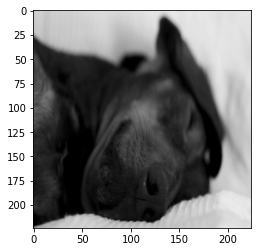

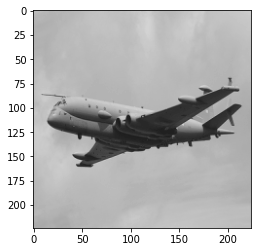

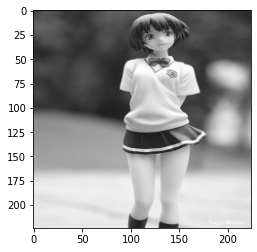

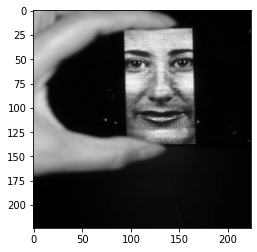

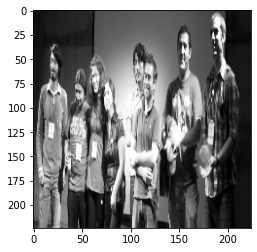

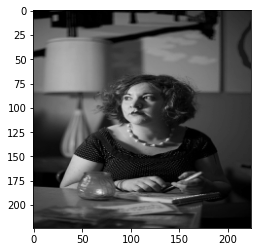

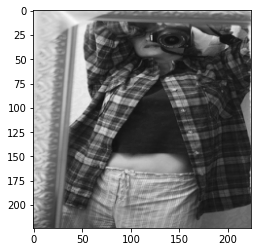

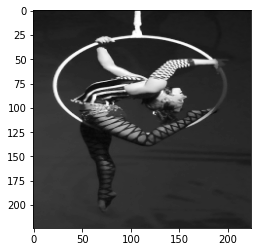

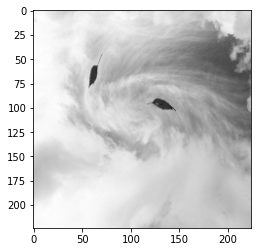

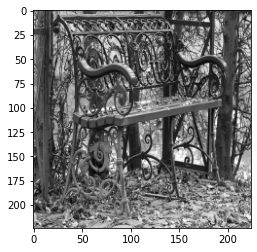

In [ ]:
showAllInput(test_truth)

In [ ]:
test_loader = torch.utils.data.DataLoader(test_input)
truth_loader = torch.utils.data.DataLoader(test_truth)

In [ ]:
test_results = test(IrtezaNet())

TESTING
tensor(1264.0240, grad_fn=<MseLossBackward>)
tensor(57.1424, grad_fn=<MseLossBackward>)
tensor(166.3217, grad_fn=<MseLossBackward>)
tensor(647.2552, grad_fn=<MseLossBackward>)
tensor(534.7393, grad_fn=<MseLossBackward>)
tensor(166.4331, grad_fn=<MseLossBackward>)
tensor(308.9364, grad_fn=<MseLossBackward>)
tensor(559.1243, grad_fn=<MseLossBackward>)
tensor(382.5356, grad_fn=<MseLossBackward>)
tensor(192.8580, grad_fn=<MseLossBackward>)


Epoch: 1 | IMAGE 1


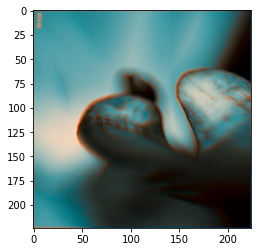

Ground Truth | IMAGE 1


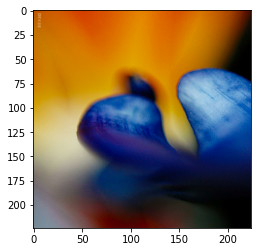

Grayscale Input | IMAGE 1


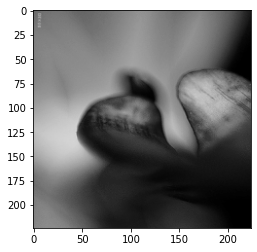

Epoch: 1 | IMAGE 1


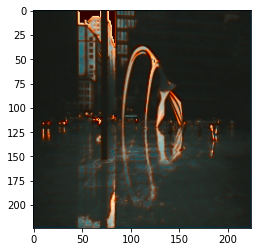

Ground Truth | IMAGE 1


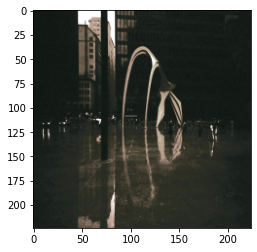

Grayscale Input | IMAGE 1


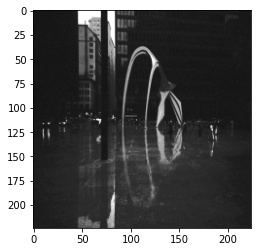

Epoch: 1 | IMAGE 1


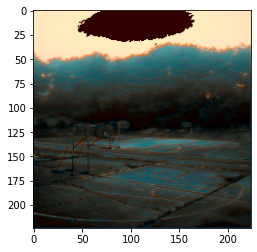

Ground Truth | IMAGE 1


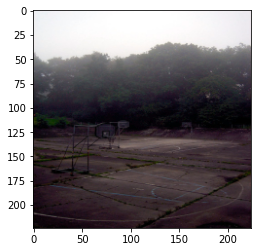

Grayscale Input | IMAGE 1


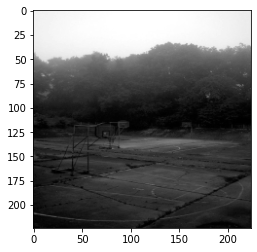

Epoch: 1 | IMAGE 1


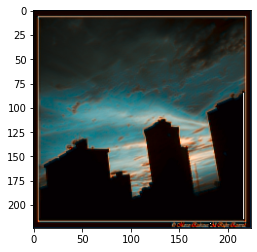

Ground Truth | IMAGE 1


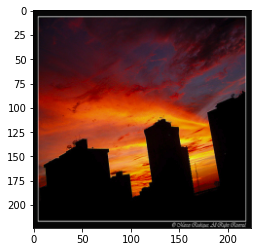

Grayscale Input | IMAGE 1


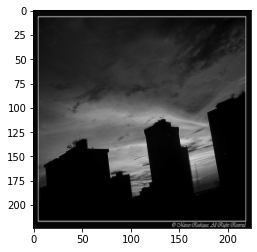

Epoch: 1 | IMAGE 1


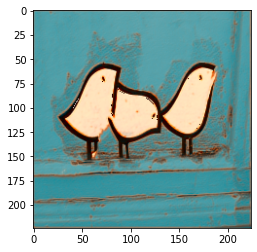

Ground Truth | IMAGE 1


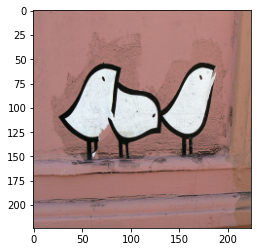

Grayscale Input | IMAGE 1


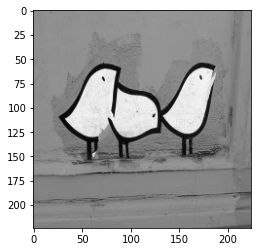

Epoch: 1 | IMAGE 1


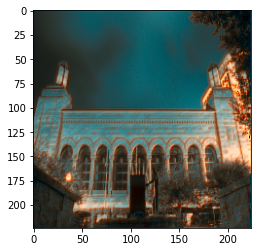

Ground Truth | IMAGE 1


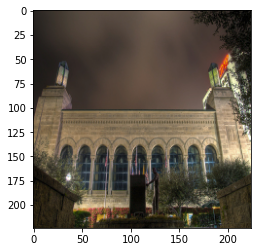

Grayscale Input | IMAGE 1


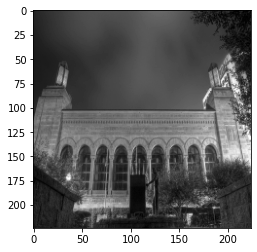

Epoch: 1 | IMAGE 1


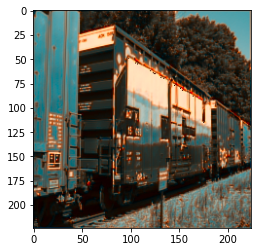

Ground Truth | IMAGE 1


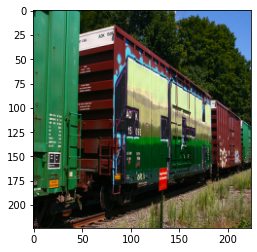

Grayscale Input | IMAGE 1


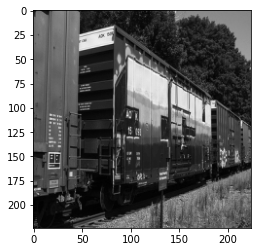

Epoch: 1 | IMAGE 1


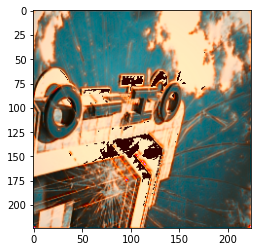

Ground Truth | IMAGE 1


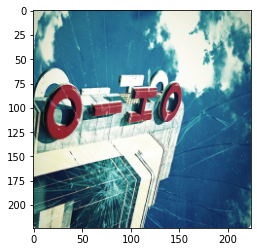

Grayscale Input | IMAGE 1


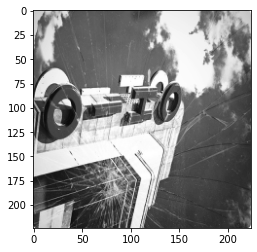

Epoch: 1 | IMAGE 1


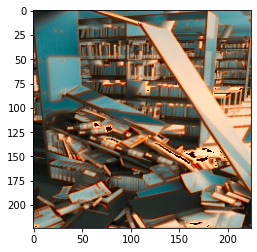

Ground Truth | IMAGE 1


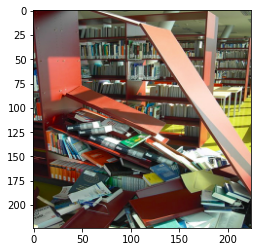

Grayscale Input | IMAGE 1


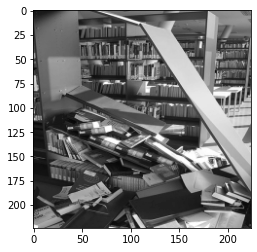

Epoch: 1 | IMAGE 1


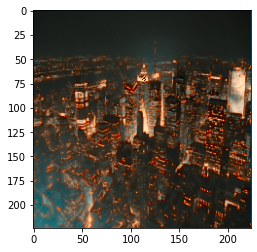

Ground Truth | IMAGE 1


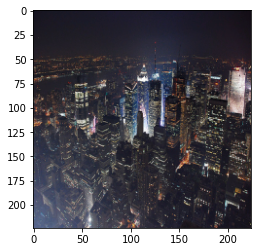

Grayscale Input | IMAGE 1


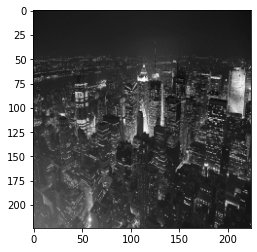

In [ ]:
showGoodTrials(test_results)

**DEMO FOR PRESENTATION**

In [ ]:
demo_path = project_path+'Grayscale_inputs'


In [ ]:
custom_transform = transforms.Compose([transforms.Resize((224,224)), 
                                transforms.ToTensor()])

demo_test = torchvision.datasets.ImageFolder(demo_path, transform=custom_transform)
demo_loader = torch.utils.data.DataLoader(demo_test)

In [ ]:
demo_data = []
a = np.zeros((3,3,224,224))

for data in demo_loader: 
  ruby = data[0].detach().numpy().squeeze().transpose(1,2,0)
  ruby = cv2.cvtColor(ruby, cv2.COLOR_RGB2Lab)
  ruby = ruby.transpose()
  demo_data.append(ruby)

In [ ]:
DEMO_LOADER_INPUT = torch.utils.data.DataLoader(demo_data)

In [ ]:
def showTest(outputs): #show demo images, b/w + colourized 
  results = []
  count_epoch = 1
  count_image = 1
  num_items = len(outputs)*len(outputs[0])

  for b in range(len(outputs[0])): #batch size
    for i in range(len(outputs)): #num of epochs
      a = outputs[i][b].detach().numpy() #tensor to array
      results.append(a) 

  for i in results:

    if count_epoch%2==0:
      print("Grayscale Input |", "IMAGE", count_image)
      i = i.transpose(2,1,0)
      i = cv2.cvtColor(i, cv2.COLOR_LAB2RGB)
      d = plt.imshow(i)
      plt.show(d)
      count_epoch=1
      count_image+=1  
    elif count_epoch < len(outputs):
      print('Colourization Attempt |',"IMAGE", count_image)
      count_epoch+=1
      pastry = i.transpose(2,1,0)
      pastry = pastry.astype("uint8")
      pastry = cv2.cvtColor(pastry, cv2.COLOR_LAB2RGB)
      pastry = pastry*1.9
      pastry = pastry.astype("uint8")
      
      c = plt.imshow(pastry) 
      plt.show(c)

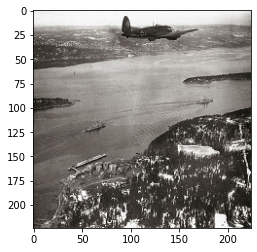

In [ ]:
for data in demo_loader: #visualize demo input
  ruby = data[0].detach().numpy().squeeze().transpose(1,2,0)
  c = plt.imshow(ruby)
  plt.show(c)

In [ ]:
save_path_demo = project_path+'save_state_final.pth'

In [ ]:
def testDemo(model): #TEST DEMO 

  results = [] 

  state = torch.load(save_path_demo)

  model.load_state_dict(state['state_dict'])

  for data in DEMO_LOADER_INPUT:
    output = model(data.float())
    results.append(output)
    results.append(data)

  print("DEMO COMPLETE")

  return results

In [ ]:
demo_results = testDemo(IrtezaNet())

DEMO COMPLETE


Colourization Attempt | IMAGE 1


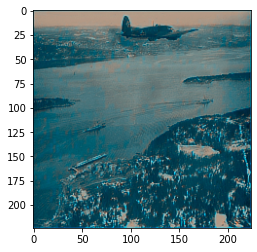

Grayscale Input | IMAGE 1


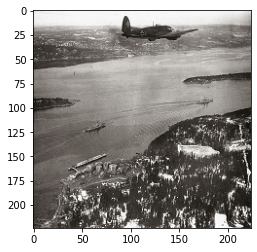

In [ ]:
showTest(demo_results)